
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# クエリ、キー、および値

:label: `sec_queries-keys-values`

これまでのところ、私たちがレビューしたすべてのネットワークは、明確に定義されたサイズの入力に大きく依存していました。たとえば、ImageNet の画像のサイズは $224 \times 224$ ピクセルであり、CNN はこのサイズに合わせて特別に調整されています。自然言語処理においても、RNN の入力サイズは明確に定義され、固定されています。可変サイズは、一度に 1 つのトークンを順番に処理するか、特別に設計された畳み込みカーネルによって対処されます (引用: `Kalchbrenner.Grefenstette.Blunsom.2014` )。このアプローチは、テキスト :cite: `Sutskever.Vinyals.Le.2014`を変換するための :numref: `sec_seq2seq`など、入力のサイズが実際に変化し、情報内容が変化する場合に重大な問題を引き起こす可能性があります。特に、長いシーケンスの場合、すでに生成されているもの、さらにはネットワークによって表示されているものすべてを追跡することは非常に困難になります。 :citet: `yang2016neural`のような明示的な追跡ヒューリスティックでも、限定的なメリットしか得られません。

これをデータベースと比較してください。最も単純な形式では、キー ($k$) と値 ($v$) のコレクションです。たとえば、データベース $\mathcal{D}$ は、タプル {("Zhang", "Aston"), ("Lipton", "Zachary"), ("Li", "Mu"), ("Smola" で構成されているとします) ", "Alex"), ("Hu", "Rachel"), ("Werness", "Brent")} 姓がキー、名が値です。たとえば、値「Mu」を返す「Li」に対する正確なクエリ ($q$) を使用して、$\mathcal{D}$ を操作できます。 ("Li", "Mu") が $\mathcal{D}$ のレコードではない場合、有効な答えはありません。近似一致も許可する場合は、代わりに ("Lipton"、"Zachary") を取得します。この非常に単純かつ自明な例ですが、それでも多くの有益なことがわかります。
- データベースのサイズに関係なく有効となるように ($k$,$v$) ペアを操作するクエリ $q$ を設計できます。
- 同じクエリでも、データベースの内容に応じて異なる回答が返される場合があります。
- 大規模な状態空間 (データベース) を操作するために実行される「コード」は、非常に単純なものにすることができます (例: 完全一致、近似一致、top-$k$)。
- 操作を効率化するためにデータベースを圧縮したり単純化したりする必要はありません。

明らかに、深層学習を説明する目的がなければ、ここで単純なデータベースを導入することはなかったでしょう。実際、これはおそらく過去 10 年間にディープラーニングに導入された最もエキサイティングな概念の 1 つであるアテンション*メカニズム*(引用: `Bahdanau.Cho.Bengio.2014` ) につながります。機械翻訳への応用の詳細については後ほど説明します。ここでは、単純に次のことを考えてみましょう。 $\mathcal{D} \stackrel{\mathrm{def}}{=} {(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf {k}_m, \mathbf{v}_m)}$*キー*と*値*の $m$ タプルのデータベース。さらに、 $\mathbf{q}$ で*クエリ*を表します。次に、$\mathcal{D}$ に対する*注意を*次のように定義できます。

 $$\mathrm{注意}(\mathbf{q}, \mathcal{D}) \stackrel{\mathrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,$$ :eqlabel: `eq_attention_pooling`

ここで、 $\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathbb{R}$ ($i = 1, \ldots, m$) はスカラー アテンション ウェイトです。この操作自体は通常、*アテンションプーリング*と呼ばれます。 *「attention」*という名前は、重み $\alpha$ が重要である (つまり、大きい) 項に操作が特別な注意を払うという事実に由来しています。そのため、$\mathcal{D}$ に対する注意により、データベースに含まれる値の線形結合が生成されます。実際、これには、1 つを除くすべての重みが 0 である特殊なケースとして上記の例が含まれています。いくつかの特殊なケースがあります。
- 重み $\alpha(\mathbf{q}, \mathbf{k}_i)$ は負ではありません。この場合、アテンション メカニズムの出力は、値 $\mathbf{v}_i$ が広がる凸円錐に含まれます。
- 重み $\alpha(\mathbf{q}, \mathbf{k}_i)$ は凸の組み合わせを形成します。つまり $\sum_i \alpha(\mathbf{q}, \mathbf{k}_i) = 1$ と$\alpha(\mathbf{q}, \mathbf{k}_i) \geq すべての $i$ に対して 0$。これは、深層学習で最も一般的な設定です。
- 重み $\alpha(\mathbf{q}, \mathbf{k}_i)$ のうちの 1 つだけが $1$ で、他のすべては $0$ です。これは従来のデータベース クエリに似ています。
- すべての重みは等しい、つまり、すべての $i$ に対して $\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{1}{m}$ となります。これはデータベース全体の平均化に相当し、深層学習では平均プーリングとも呼ばれます。

重みの合計が $1$ になるようにするための一般的な戦略は、次のようにして重みを正規化することです。

 $$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{{\sum_j} \alpha(\mathbf{ q}, \mathbf{k}_j)}.$$

特に、重みが負でないことを保証するには、べき乗に頼ることができます。これは、*任意の*関数 $a(\mathbf{q}, \mathbf{k})$ を選択し、多項モデルに使用されるソフトマックス演算を次のように適用できることを意味します。

 $$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a( \mathbf{q}、\mathbf{k}_j))}。 $$ :eqlabel: `eq_softmax_attention`

この操作は、すべての深層学習フレームワークですぐに利用できます。これは微分可能であり、その勾配は決して消えることがなく、これらすべてがモデルにおいて望ましい特性です。ただし、上で紹介したアテンション メカニズムが唯一のオプションではないことに注意してください。たとえば、強化学習手法を使用してトレーニングできる微分不可能なアテンション モデルを設計できます (引用: `Mnih.Heess.Graves.ea.2014` )。ご想像のとおり、このようなモデルのトレーニングは非常に複雑です。したがって、現代のアテンション研究の大部分は、 :numref: `fig_qkv`で概説されているフレームワークに従っています。したがって、私たちはこの微分可能なメカニズムのファミリーに焦点を当てて説明します。 

![](../img/qkv.svg) :ラベル: `fig_qkv`

非常に注目すべき点は、操作するスペースが大きいにもかかわらず、キーと値のセットに対して実行する実際の「コード」、つまりクエリが非常に簡潔になることです。これは、学習にあまり多くのパラメータを必要としないため、ネットワーク層にとって望ましい特性です。アテンション プーリング操作の実行方法を変更することなく、アテンションを任意の大規模データベースで操作できるという事実も同様に便利です。


In [1]:
import torch
from d2l import torch as d2l


## 視覚化

アテンション メカニズムの利点の 1 つは、特に重みが負でなく、合計が $1$ になる場合に非常に直感的になることです。この場合、大きな重みをモデルが関連性のあるコンポーネントを選択する方法として*解釈する*可能性があります。これは優れた直観ですが、それは単なる*直観で*あることを覚えておくことが重要です。とにかく、さまざまな異なるクエリを適用するときに、指定されたキーのセットに対するその効果を視覚化したい場合があります。この機能は後で役に立ちます。

したがって、 `show_heatmaps`関数を定義します。入力として (アテンションの重みの) 行列を使用するのではなく、4 軸のテンソルを使用して、さまざまなクエリと重みの配列を許可することに注意してください。したがって、入力`matrices`次のような形状になります (表示行数、表示列数、クエリ数、キー数)。これは、後でトランスフォーマーの設計に使用される :numref: `sec_multihead-attention`の動作を視覚化するときに役立ちます。


In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);


簡単な健全性チェックとして、クエリとキーが同じ場合にのみアテンションの重みが 1 になるケースを表す恒等行列を視覚化してみましょう。


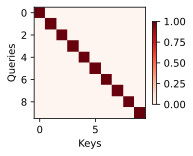

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')


## まとめ

アテンション メカニズムを使用すると、多くの (キー、値) ペアからデータを集約できます。これまでの議論は非常に抽象的で、単にデータをプールする方法について説明したものでした。これらの謎のクエリ、キー、値がどこから発生するのかについては、まだ説明されていません。ここでは直感が役に立つかもしれません。たとえば、回帰設定では、クエリが回帰を実行する必要がある場所に対応している可能性があります。キーは過去のデータが観測された場所、値は（回帰）値そのものです。これはいわゆる Nadaraya-Watson 推定器です:cite: `Nadaraya.1964,Watson.1964`で、次のセクションで検討します。

設計により、アテンション メカニズムは、ニューラル ネットワークがセットから要素を選択し、表現に関連する重み付けされた合計を構築できる*微分可能な*制御手段を提供します。

## 演習
1. 従来のデータベースで使用されている近似 (キー、クエリ) 一致を再実装したいとします。どのアテンション関数を選択しますか?
1. アテンション関数が $a(\mathbf{q}, \mathbf{k} *i) = \mathbf{q}^\top \mathbf{k}_i$ で与えられ、 $\mathbf{k}_i = であるとします。 \mathbf{v}_i$ ($i = 1、\ldots、m$)。 :eqref: `eq_softmax_attention`でソフトマックス正規化を使用する場合のキーにわたる確率分布を $p(\mathbf{k}_i; \mathbf{q})$ で示します。 $\nabla {\mathbf{q}} \mathop{\mathrm{tention}}(\mathbf{q}, \mathcal{D}) = \mathrm{Cov}_{p(\mathbf{k}_i であることを証明してください*; \mathbf{q})}[\mathbf{k}_i]$。
1. アテンション メカニズムを使用して微分可能な検索エンジンを設計します。
1. スクイーズ ネットワークと励起ネットワーク (引用: `Hu.Shen.Sun.2018`の設計を確認し、注意メカニズムのレンズを通して解釈します。



[ディスカッション](https://discuss.d2l.ai/t/1592)
